<a href="https://colab.research.google.com/github/TheUnknown477/Fraud-detection-using-deep-learning/blob/main/Fraud_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SETUP & IMPORTS

In [1]:
!pip install kaggle river torch torchvision torchaudio pandas==2.2.2 numpy scikit-learn xgboost

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, recall_score
from river.drift import ADWIN
from collections import deque
import matplotlib.pyplot as plt
import joblib
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# 2. SECURE KAGGLE DATA DOWNLOAD

In [2]:
from google.colab import files
print("Please upload your kaggle.json file now:")
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c ieee-fraud-detection -p /content/data
!unzip -q /content/data/ieee-fraud-detection.zip -d /content/data


Please upload your kaggle.json file now:


Saving kaggle.json to kaggle.json
  0% 0.00/118M [00:00<?, ?B/s]
100% 118M/118M [00:00<00:00, 1.50GB/s]


# 3. DATA & PREPROCESSING

In [3]:
# Load data
train_tr = pd.read_csv('/content/data/train_transaction.csv')
train_id = pd.read_csv('/content/data/train_identity.csv')
data = train_tr.merge(train_id, on='TransactionID', how='left')

# Define features
target_col = 'isFraud'
time_col = 'TransactionDT'
feature_cols = [
    'TransactionDT', 'TransactionAmt', 'ProductCD',
    'card1','card2','card3','card4',
    'addr1','DeviceType',
    'V12','V13','V14','V15'
]

# Sort by time for streaming simulation
data = data[feature_cols + [target_col]].sort_values(time_col).reset_index(drop=True)

# Handling Missing Values
for col in data.columns:
    if data[col].dtype == 'O':
        data[col] = data[col].fillna('missing')
    else:
        data[col] = data[col].fillna(data[col].median())

# Encoding Categoricals
cat_cols = ['ProductCD', 'card4', 'DeviceType']
encoders_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders_dict[col] = le

# Identify numeric columns (excluding time & target)
num_cols = [c for c in data.columns if c not in cat_cols + [target_col, time_col]]

# Scaling Numerics
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Save input feature order for the App
feature_input_cols = num_cols + cat_cols

# Split: 60% Historical (Train), 40% Streaming (Test)
split_idx = int(0.6 * len(data))
hist_df = data.iloc[:split_idx].reset_index(drop=True)
stream_df = data.iloc[split_idx:].reset_index(drop=True)

# Calculate Class Weight for Imbalance
neg_count = (hist_df[target_col] == 0).sum()
pos_count = (hist_df[target_col] == 1).sum()
pos_weight = torch.tensor([neg_count / pos_count]).to(device)
print(f"Historical set: {len(hist_df)}, Streaming set: {len(stream_df)}")
print(f"Fraud Ratio: {pos_count/len(hist_df):.4f}, Pos Weight: {pos_weight.item():.2f}")

Historical set: 354324, Streaming set: 236216
Fraud Ratio: 0.0338, Pos Weight: 28.56


# 4. BASELINE: XGBoost

In [4]:
print("\nTraining XGBoost Baseline...")
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    scale_pos_weight=pos_weight.item(),
    eval_metric='auc',
    use_label_encoder=False
)
xgb_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_xgb = xgb_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
xgb_auc = roc_auc_score(stream_df[target_col], y_pred_xgb)
print(f"XGBoost Baseline ROC-AUC on Stream Data: {xgb_auc:.4f}")



Training XGBoost Baseline...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:33:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Baseline ROC-AUC on Stream Data: 0.7773


# 5. DEEP LEARNING MODEL

In [5]:
class FraudDataset(Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df[feature_input_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1) # No Sigmoid here, handled by BCEWithLogitsLoss
        )
    def forward(self, x): return self.net(x)

# 6. Initial Training (Static Baseline)

In [6]:
train_ds = FraudDataset(hist_df)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)

model = MLP(input_dim=len(feature_input_cols)).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("\nTraining Initial Static Model...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1,1)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(X_batch)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_ds):.4f}")


Training Initial Static Model...
Epoch 1, Loss: 1.1954
Epoch 2, Loss: 1.1673
Epoch 3, Loss: 1.1578
Epoch 4, Loss: 1.1498
Epoch 5, Loss: 1.1449


# 7. Utils : MC Dropout & Metrics

In [7]:
def mc_predict(model, X, T=20):
    model.eval() # Set model to evaluation mode (disables Batchnorm training and Dropout)
    # Manually re-enable dropout layers for MC Dropout
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train() # Re-enable dropout

    probs = []
    with torch.no_grad():
        for _ in range(T):
            logits = model(X)
            probs.append(torch.sigmoid(logits).cpu().numpy())
    probs = np.stack(probs, axis=0)

    # Restore original model state (eval mode for all layers) after MC Dropout
    model.eval()

    # Return mean prob and variance
    return probs.mean(axis=0).reshape(-1), probs.var(axis=0).reshape(-1)

def compute_metrics(y_true, y_score):
    if len(np.unique(y_true)) < 2: return None
    roc = roc_auc_score(y_true, y_score)
    pr, rc, _ = precision_recall_curve(y_true, y_score)

    # Recall at 5% FPR
    fpr_target = 0.05
    # Sort scores descending
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score_sorted = np.array(y_score)[desc_score_indices]
    y_true_sorted = np.array(y_true)[desc_score_indices]

    # Find threshold index for 5% FPR
    neg_count = (y_true_sorted == 0).sum()
    fp_limit = neg_count * fpr_target
    fp_count = 0
    cutoff_idx = len(y_true_sorted)

    for i, label in enumerate(y_true_sorted):
        if label == 0: fp_count += 1
        if fp_count > fp_limit:
            cutoff_idx = i
            break

    # Calculate recall up to that cutoff
    if np.sum(y_true_sorted) > 0:
        recall_at_fpr = np.sum(y_true_sorted[:cutoff_idx]) / np.sum(y_true_sorted)
    else:
        recall_at_fpr = 0.0

    return {"roc_auc": roc, "pr_auc": auc(rc, pr), "recall_at_5fpr": recall_at_fpr}

# 8. EXPERIMENT: FULL METHOD

In [8]:
def run_full_method(df, delay=1000, chunk=50000):
    print("\nRunning Full Adaptive Method with Uncertainty & Drift Detection...")
    adwin = ADWIN()
    label_queue = deque()
    replay_buffer = []
    drift_points = []
    metrics_log = []

    chunk_y_true, chunk_y_pred = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for i, row in df.iterrows():
        X = torch.tensor(row[feature_input_cols].values, dtype=torch.float32).unsqueeze(0).to(device)
        y = int(row[target_col])

        # 1. Inference with Uncertainty
        mean_p, var_p = mc_predict(model, X)
        pred_prob = float(mean_p[0])

        chunk_y_true.append(y)
        chunk_y_pred.append(pred_prob)

        # 2. Delayed Label Queue
        is_uncertain = var_p[0] > 0.02 # Tune threshold if needed
        label_queue.append((X, y, is_uncertain))

        # 3. Label Reveal & Update
        if len(label_queue) > delay:
            past_X, past_y, was_uncertain = label_queue.popleft()

            # Drift Check
            model.eval()
            with torch.no_grad():
                drift_prob = torch.sigmoid(model(past_X)).item()
                drift_pred = 1 if drift_prob >= 0.5 else 0

            err = int(drift_pred != past_y)
            adwin.update(err)

            if adwin.drift_detected:
                drift_points.append(i)

            # Update Strategy
            if was_uncertain or adwin.drift_detected:
                replay_buffer.append((past_X, past_y))

            # Mini-batch update
            if len(replay_buffer) >= 64:
                batch = replay_buffer[-64:]
                bX = torch.cat([b[0] for b in batch])
                by = torch.tensor([b[1] for b in batch], dtype=torch.float32).view(-1,1).to(device)

                model.train()
                optimizer.zero_grad()
                loss = criterion(model(bX), by)
                loss.backward()
                optimizer.step()
                replay_buffer = []

        # 4. Logging
        if (i+1) % chunk == 0:
            m = compute_metrics(chunk_y_true, chunk_y_pred)
            if m:
                m['index'] = i
                metrics_log.append(m)
                print(f"Index {i}: PR-AUC={m['pr_auc']:.4f}, Recall@5%FPR={m['recall_at_5fpr']:.4f}, Drifts={len(drift_points)}")
            chunk_y_true, chunk_y_pred = [], []

    return metrics_log, drift_points

# Run it!
metrics_log, drift_points = run_full_method(stream_df)


Running Full Adaptive Method with Uncertainty & Drift Detection...
Index 49999: PR-AUC=0.1589, Recall@5%FPR=0.3286, Drifts=4
Index 99999: PR-AUC=0.1126, Recall@5%FPR=0.2319, Drifts=11
Index 149999: PR-AUC=0.1003, Recall@5%FPR=0.2525, Drifts=14
Index 199999: PR-AUC=0.1073, Recall@5%FPR=0.2564, Drifts=28


# 9. RESULTS & PLOTTING

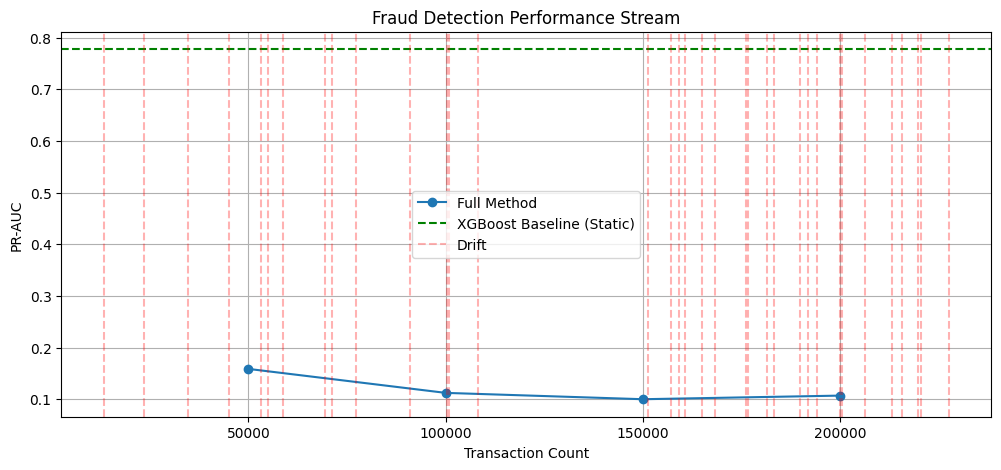

In [9]:
df_res = pd.DataFrame(metrics_log)
if not df_res.empty:
    plt.figure(figsize=(12, 5))
    plt.plot(df_res['index'], df_res['pr_auc'], marker='o', label='Full Method')
    plt.axhline(y=xgb_auc, color='g', linestyle='--', label='XGBoost Baseline (Static)')
    first_drift = True
    for d in drift_points:
        if first_drift:
            plt.axvline(d, color='r', linestyle='--', alpha=0.3, label='Drift')
            first_drift = False
        else:
            plt.axvline(d, color='r', linestyle='--', alpha=0.3) # No label for subsequent drifts
    plt.title("Fraud Detection Performance Stream")
    plt.xlabel("Transaction Count")
    plt.ylabel("PR-AUC")
    plt.legend()
    plt.grid(True)
    plt.savefig("performance_plot.png")
    plt.show()

# 10. DEPLOYMENT DEMO & EXPORT

In [10]:
def predict_transaction(transaction_dict):
    """Simulates API endpoint"""
    model.eval()
    processed_values = {} # Use a dictionary to store values with their column names

    for col in feature_input_cols:
        val = transaction_dict.get(col, 0)
        # Handle categorical encoding (naive lookup)
        if col in encoders_dict:
            try:
                val = encoders_dict[col].transform([str(val)])[0]
            except ValueError:
                # If a category is not seen during training, default to 0
                val = 0
        processed_values[col] = float(val)

    # Convert the processed values to a DataFrame
    input_df = pd.DataFrame([processed_values])

    # Scale only the numerical features. Passing a DataFrame ensures feature names are used.
    input_df[num_cols] = scaler.transform(input_df[num_cols])

    # Convert the DataFrame to a tensor, ensuring column order is maintained
    x_tensor = torch.tensor(input_df[feature_input_cols].values, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(x_tensor)
        prob = torch.sigmoid(logits).item()

    return {"fraud_probability": prob, "alert": "HIGH RISK" if prob > 0.8 else "OK"}

# Test API
dummy_tx = stream_df.iloc[0].to_dict()
print(f"\n[API TEST] Input Amount: {dummy_tx['TransactionAmt']}")
print(f"[API TEST] Output: {predict_transaction(dummy_tx)}")

# Export artifacts
torch.save(model.state_dict(), 'fraud_mlp.pth')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoders_dict, 'encoders.pkl')
joblib.dump(feature_input_cols, 'feature_cols.pkl')
df_res.to_csv('final_results.csv', index=False)

print("\nAll files saved! Ready for App building.")


[API TEST] Input Amount: 0.3803810893393937
[API TEST] Output: {'fraud_probability': 0.8184919953346252, 'alert': 'HIGH RISK'}

All files saved! Ready for App building.
